In [1]:
import numpy as np
import sklearn.preprocessing as preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial.distance import hamming
from sklearn.externals import joblib
import csv
import matplotlib.pyplot as plt
from LearningDataAdapter import LearningDataAdapter
from ModelEvaluator import ModelEvaluator
from sklearn.metrics import roc_curve
import glob
from LearningScore import learning_curve

Importing test sample... 

Plotting ROC curve...
./models/logistic.pkl

Plotting probability distribution...

Plotting learning curve......
Importing training data...
Calculating learning curves...
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=None)


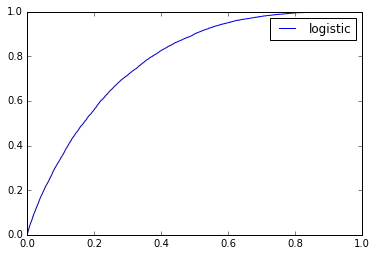

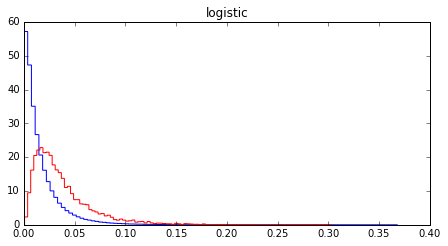

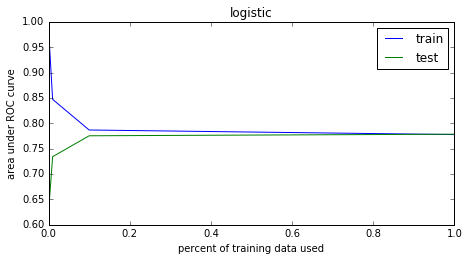

In [19]:
%matplotlib inline

print 'Importing test sample... '
adapter = LearningDataAdapter(for_learning=True)
adapter.adapt_file('data/validate.csv')
X_num, X_cat = adapter.X_num, adapter.X_cat

imp = joblib.load("./models/imputer.pkl")
scaler = joblib.load("./models/scaler.pkl")
enc = joblib.load("./models/encoder.pkl")
evaluator = ModelEvaluator(
imputer=imp, scaler=scaler,
encoder=enc)

pred_x = evaluator.preprocess(X_num,X_cat)
pred_w, pred_y = adapter.w, adapter.y
print


# plot
# this step will plot ROC curve, probability distribution for signal/background
# and learning curve for each model.

print 'Plotting ROC curve...'
plt.figure(1)    
model_list = glob.glob('./models/*.pkl')
for model in model_list:
    if model not in ['./models/encoder.pkl','./models/scaler.pkl','./models/imputer.pkl']:
        print model
        rf = joblib.load(model)
        evaluator = ModelEvaluator(
        imputer=imp, scaler=scaler,
        encoder=enc, model=rf
        )

        #y_pred = evaluator.predict(X_num, X_cat)
        prob1 = evaluator.predict_proba(X_num, X_cat)[:,1]
        fpr,tpr,thresholds = roc_curve(pred_y, prob1, sample_weight=pred_w)
        plt.plot(fpr,tpr,label=model[9:-4])
        
plt.legend()
plt.savefig("./roc.png")
print


print 'Plotting probability distribution...'
plt.figure(2,figsize=(16,8))
number_of_models = len(model_list)
count = 0
for model in model_list:
    if model not in ['./models/encoder.pkl','./models/scaler.pkl','./models/imputer.pkl']:
        count = count + 1
        rf = joblib.load(model)
        evaluator = ModelEvaluator(
        imputer=imp, scaler=scaler,
        encoder=enc, model=rf
        )

        prob1 = evaluator.predict_proba(X_num, X_cat)[:,1]
        signal = prob1[pred_y==1]
        background = prob1[pred_y==0]
        plt.subplot(len(model_list)/2, 2, count)
        plt.hist(background,color='b',bins=100,normed='true',histtype='step')
        plt.hist(signal,color='r',bins=100,normed='true',histtype='step')
        plt.title(model[9:-4])
plt.savefig("./density_plot.png")
print



print 'Plotting learning curve......'
plt.figure(3,figsize=(16,8))
print 'Importing training data...'
adapter.adapt_file('data/train.csv')
X_num, X_cat = adapter.X_num, adapter.X_cat
evaluator = ModelEvaluator(
imputer=imp, scaler=scaler,
encoder=enc)
train_w, train_y = adapter.w, adapter.y
train_x = evaluator.preprocess(X_num,X_cat)

print 'Calculating learning curves...'
number_of_models = len(model_list)
count = 0
for model in model_list:
    if model not in ['./models/encoder.pkl','./models/scaler.pkl','./models/imputer.pkl']:
        count = count + 1
        plt.subplot(len(model_list)/2, 2, count)
        rf = joblib.load(model)
        print rf
        lcr = learning_curve(train_x,train_y,train_w,pred_x,pred_y,pred_w,rf)
        train_size, train_list, test_list = lcr.learning_curve()
        plt.plot(train_size,train_list,label='train')
        plt.plot(train_size,test_list,label='test')
        plt.xlabel('percent of training data used')
        plt.ylabel('area under ROC curve')
        plt.title(model[9:-4])
plt.legend()